# scikit-learn: Training Neural Networks for Classification and Dimensionality Reduction

This notebook demonstrates example neural network setups for **image classification** and **dimensionality reduction** tasks using `scikit-learn`.

The examples serve as complement and comparison for exploring neural networks with the `edu.yaprnn` app.

Loading MNIST images from E:\edu.yaprnn\src\main\resources\digits.idx3-ubyte


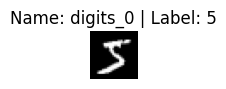

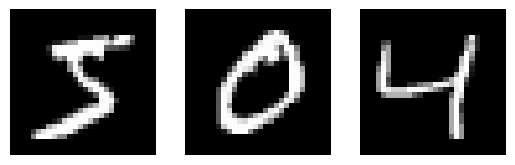

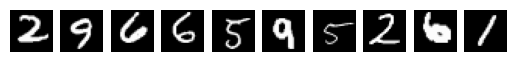

(36000, 784) (36000, 10) (36000,) (12000, 784) (12000, 10) (12000,)
(48000, 784) (48000, 10) (48000,) (12000, 784) (12000, 10) (12000,)
(48000, 784) (48000, 10) (48000,) (12000, 784) (12000, 10) (12000,)


In [1]:
from sklearn.model_selection import train_test_split

import mnist_utils
import model_utils

mnist_images, image_size, X, random_x_indices, random_feature_indices, y, labels = mnist_utils.from_mnist_images()

digits_train_32k_test_12k = train_test_split(X, y, labels, train_size=0.6, test_size=0.2, random_state=model_utils.SEED)
digits_images_from_labels = train_test_split(X, y, labels, train_size=0.8, test_size=0.2, random_state=model_utils.SEED)
digits_input_reconstruction = train_test_split(X, y, labels, train_size=0.8, test_size=0.2,
                                               random_state=model_utils.SEED)

mnist_utils.from_dataset(digits_train_32k_test_12k, explain=True)
mnist_utils.from_dataset(digits_images_from_labels, explain=True)
mnist_utils.from_dataset(digits_input_reconstruction, explain=True)

None

In [2]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
import numpy as np


def count_parameters(_model):
    count_weights = np.sum([np.prod(w.shape) for w in _model.coefs_])
    count_bias = np.sum([np.prod(w.shape) for w in _model.intercepts_])
    return count_weights + count_bias

## Digits Classification

This model is configured as follows:

- **Architecture**:
  - Input layer: 784 neurons (inferred)
  - 2 hidden layers:
    - Layer 1: 20 neurons
    - Layer 2: 15 neurons
  - Output layer: 10 neurons (inferred)
  - Total parameters: `((784 + 1) * 20) + ((20 + 1) * 15) + ((15 + 1) * 10) = 16175` (Biases included)
- **Activation Function**: relu as replacement for gelu (latter not supported by scikit-learn)
- **Optimizer**: Stochastic Gradient Descent (SGD)
  - Learning rate: 0.02 / 32 (=batch_size)
  - Momentum: 0.2 with Nesterov term
  - L2-weight-decay: 0.001
  - L1-weight-decay: not supported by scikit-learn
- **Loss Function**: Mean Squared Error (MSE)

In [3]:
_, _, X_train, y_train, _, _ = mnist_utils.from_dataset(digits_train_32k_test_12k)

classification_model = MLPClassifier(hidden_layer_sizes=tuple(model_utils.CLASSIFICATION_FEATURES), activation='relu',
                                     solver='sgd', batch_size=model_utils.BATCH_SIZE,
                                     learning_rate_init=model_utils.BATCH_LEARNING_RATE,
                                     max_iter=model_utils.CLASSIFICATION_EPOCHS, momentum=model_utils.MOMENTUM,
                                     nesterovs_momentum=model_utils.NESTEROV_MOMENTUM, alpha=model_utils.L2_DECAY,
                                     random_state=model_utils.SEED, verbose=True)
classification_model_predict = lambda X: classification_model.predict_proba(X)

classification_model.fit(X_train, y_train)

print(f'Actual number of parameters: {count_parameters(classification_model)}')

Iteration 1, loss = 4.52139819
Iteration 2, loss = 3.34232259
Iteration 3, loss = 3.16350515
Iteration 4, loss = 2.92066109
Iteration 5, loss = 2.66757400
Iteration 6, loss = 2.42528865
Iteration 7, loss = 2.20159393
Iteration 8, loss = 1.99213965
Iteration 9, loss = 1.79388989
Iteration 10, loss = 1.62013548
Iteration 11, loss = 1.48243813
Iteration 12, loss = 1.37325200
Iteration 13, loss = 1.28915201
Iteration 14, loss = 1.22284307
Iteration 15, loss = 1.16831211
Iteration 16, loss = 1.12291976
Iteration 17, loss = 1.08371286
Iteration 18, loss = 1.04933093
Iteration 19, loss = 1.01892801
Iteration 20, loss = 0.99205637
Iteration 21, loss = 0.96785248
Iteration 22, loss = 0.94582727
Iteration 23, loss = 0.92606816
Iteration 24, loss = 0.90767629
Iteration 25, loss = 0.89093960
Iteration 26, loss = 0.87553465
Iteration 27, loss = 0.86142720
Iteration 28, loss = 0.84837910
Iteration 29, loss = 0.83605796
Iteration 30, loss = 0.82448322
Iteration 31, loss = 0.81373441
Iteration 32, los

E:\edu.yaprnn\notebooks\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy on training set: 0.9063333333333333
Accuracy on test set: 0.9059166666666667
Random test indices: [ 2050  4746 11802  9692 11268]


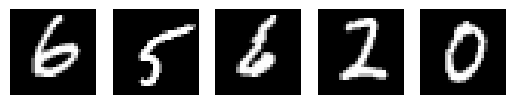

Actual labels of random test indices: [6 5 6 2 0]
Predicted labels of random test indices: [6 5 6 2 0]


array([['0.0', '0.0', '0.01', '0.0', '0.01', '0.02', '1.0', '0.0',
        '0.01', '0.0'],
       ['0.04', '0.0', '0.0', '0.0', '0.02', '0.97', '0.01', '0.01',
        '0.02', '0.01'],
       ['0.0', '0.0', '0.27', '0.0', '0.0', '0.02', '0.97', '0.0',
        '0.01', '0.0'],
       ['0.0', '0.04', '0.95', '0.01', '0.0', '0.0', '0.01', '0.0',
        '0.0', '0.0'],
       ['0.96', '0.0', '0.02', '0.0', '0.0', '0.01', '0.0', '0.0',
        '0.01', '0.0']], dtype='<U32')

In [4]:
_, _, X_train, y_train, X_test, y_test = mnist_utils.from_dataset(digits_train_32k_test_12k)

print(f'Accuracy on training set: {model_utils.calculate_accuracy(classification_model_predict, X_train, y_train)}')
print(f'Accuracy on test set: {model_utils.calculate_accuracy(classification_model_predict, X_test, y_test)}')

random_test_indices = np.random.choice(X_test.shape[0], 5, replace=False)
print(f'Random test indices: {random_test_indices}')

mnist_utils.plot_images(X_test[random_test_indices], image_size=image_size, cmap='gray')
print(f'Actual labels of random test indices: {np.argmax(y_test[random_test_indices], axis=1)}')

predicted = classification_model_predict(X_test[random_test_indices])
print(f'Predicted labels of random test indices: {np.argmax(predicted, axis=1)}')
predicted.round(2).astype('str')

## Dimensionality Reduction with an Autoencoder

This section demonstrates the use of two neural networks for dimensionality reduction. These networks rely on a bottleneck layer in their architecture to reduce the input data's dimensionality.

Instead of using predefined methods to extract the most relevant features, the networks are trained using backpropagation. This approach enables the model to automatically learn a transformation into a compressed feature space along with its inverse transformation to reconstruct the input data as accurately as possible.

### Autoencoder Network with 12 Neurons Bottleneck Layer

This model is configured as follows:

- **Architecture**:
  - Input layer: 784 neurons
  - 5 hidden layers:
    - Layer 1: 196 neurons
    - Layer 2: 49 neurons
    - Layer 3: 12 neurons
    - Layer 4: 49 neurons
    - Layer 5: 196 neurons
  - Output layer: 784 neurons
  - Total parameters: 328998 (Biases included)
- **Activation Function**: relu as replacement for gelu (latter not supported by scikit-learn)
- **Optimizer**: Stochastic Gradient Descent (SGD)
  - Learning rate: 0.02 / 32 (=batch_size)
  - Momentum: 0.2 with Nesterov term
  - L2-weight-decay: 0.001
  - L1-weight-decay: not supported by scikit-learn
- **Loss Function**: Mean Squared Error (MSE)

In [5]:
_, _, X_train, _, _, _ = mnist_utils.from_dataset(digits_input_reconstruction)

autoencoder_model = MLPRegressor(hidden_layer_sizes=tuple(model_utils.AUTOENCODER_FEATURES), activation='relu',
                                 solver='sgd',
                                 batch_size=model_utils.BATCH_SIZE, learning_rate_init=model_utils.BATCH_LEARNING_RATE,
                                 max_iter=model_utils.AUTOENCODER_EPOCHS, momentum=model_utils.MOMENTUM,
                                 nesterovs_momentum=model_utils.NESTEROV_MOMENTUM, alpha=model_utils.L2_DECAY,
                                 random_state=model_utils.SEED, verbose=True)
autoencoder_model_predict = lambda X: autoencoder_model.predict(X)

autoencoder_model.fit(X_train, X_train)

print(f'Actual number of parameters: {count_parameters(autoencoder_model)}')

Iteration 1, loss = 0.04631077
Iteration 2, loss = 0.04098155
Iteration 3, loss = 0.03662498
Iteration 4, loss = 0.03468729
Iteration 5, loss = 0.03350047
Iteration 6, loss = 0.03295239
Iteration 7, loss = 0.03257217
Iteration 8, loss = 0.03213003
Iteration 9, loss = 0.03176814
Iteration 10, loss = 0.03150502
Iteration 11, loss = 0.03127730
Iteration 12, loss = 0.03106330
Iteration 13, loss = 0.03085956
Iteration 14, loss = 0.03066799
Iteration 15, loss = 0.03048743
Iteration 16, loss = 0.03031558
Iteration 17, loss = 0.03015257
Iteration 18, loss = 0.02999877
Iteration 19, loss = 0.02985547
Iteration 20, loss = 0.02972298
Iteration 21, loss = 0.02960000
Iteration 22, loss = 0.02948376
Iteration 23, loss = 0.02937462
Iteration 24, loss = 0.02927155
Iteration 25, loss = 0.02917087
Iteration 26, loss = 0.02907062
Iteration 27, loss = 0.02894793
Iteration 28, loss = 0.02881111
Iteration 29, loss = 0.02866720
Iteration 30, loss = 0.02853343
Iteration 31, loss = 0.02841692
Iteration 32, los

Loss X_train: 0.028660748153924942
Loss X_test: 0.028676113113760948
Random test indices: [ 1556  5221  8246 10046  4017]


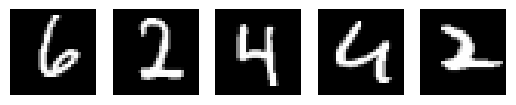

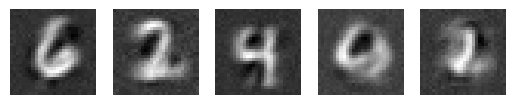

In [6]:
_, _, X_train, _, X_test, _ = mnist_utils.from_dataset(digits_input_reconstruction)

print(f'Loss X_train: {model_utils.mse_loss(autoencoder_model_predict, X_train, X_train)}')
print(f'Loss X_test: {model_utils.mse_loss(autoencoder_model_predict, X_test, X_test)}')

random_test_indices = np.random.choice(X_test.shape[0], 5, replace=False)
print(f'Random test indices: {random_test_indices}')

original = X_test[random_test_indices]
mnist_utils.plot_images(original, image_size=image_size, cmap='gray')

restored = autoencoder_model_predict(original)
mnist_utils.plot_images(restored, image_size=image_size, cmap='gray')